1. DATA PREPARATION

The data preparation process involves loading the streamreview datataset with a pandas.read_csv into our dataframe, viewing the first 5 rows in the dataframe to know what we are working with, determining the shape of the dataset, and describing the dataset with the df.describe()

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load data with pd.read_csv
df = pd.read_csv(r"C:\Users\User\Downloads\archive (2)\steam_reviews.csv")
df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [4]:
#Shape of the dataset
df.shape

(434891, 8)

In [5]:
#Describe data
df.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


In [6]:
#calculate the length of the 'review' column for each row
#convert the review text to a string and then find its length
df['review_length'] = df.apply(lambda row: len(str(row['review'])), axis=1)
#create a new column 'recommendation_int'that compares the values in the 'recommendation' column
#with 'Recommended' and store the result as a boolean in the new column.
df['recommendation_int'] = df['recommendation'] == 'Recommended'
#convert the boolean values in column to integers (0 for False, 1 for True).
df['recommendation_int'] = df['recommendation_int'].astype(int)
df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_length,recommendation_int
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,195,1
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,4,1
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,171,1
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,2094,1
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1397,1


Explanatory Data Analysis

First off, an overview of the distribution of reviews across different game titles, allows you to identify the most popular or widely reviewed games. Hence, we create a plot that visualizes the distribution of reviews according to the title of the game

<Axes: xlabel='review', ylabel='title'>

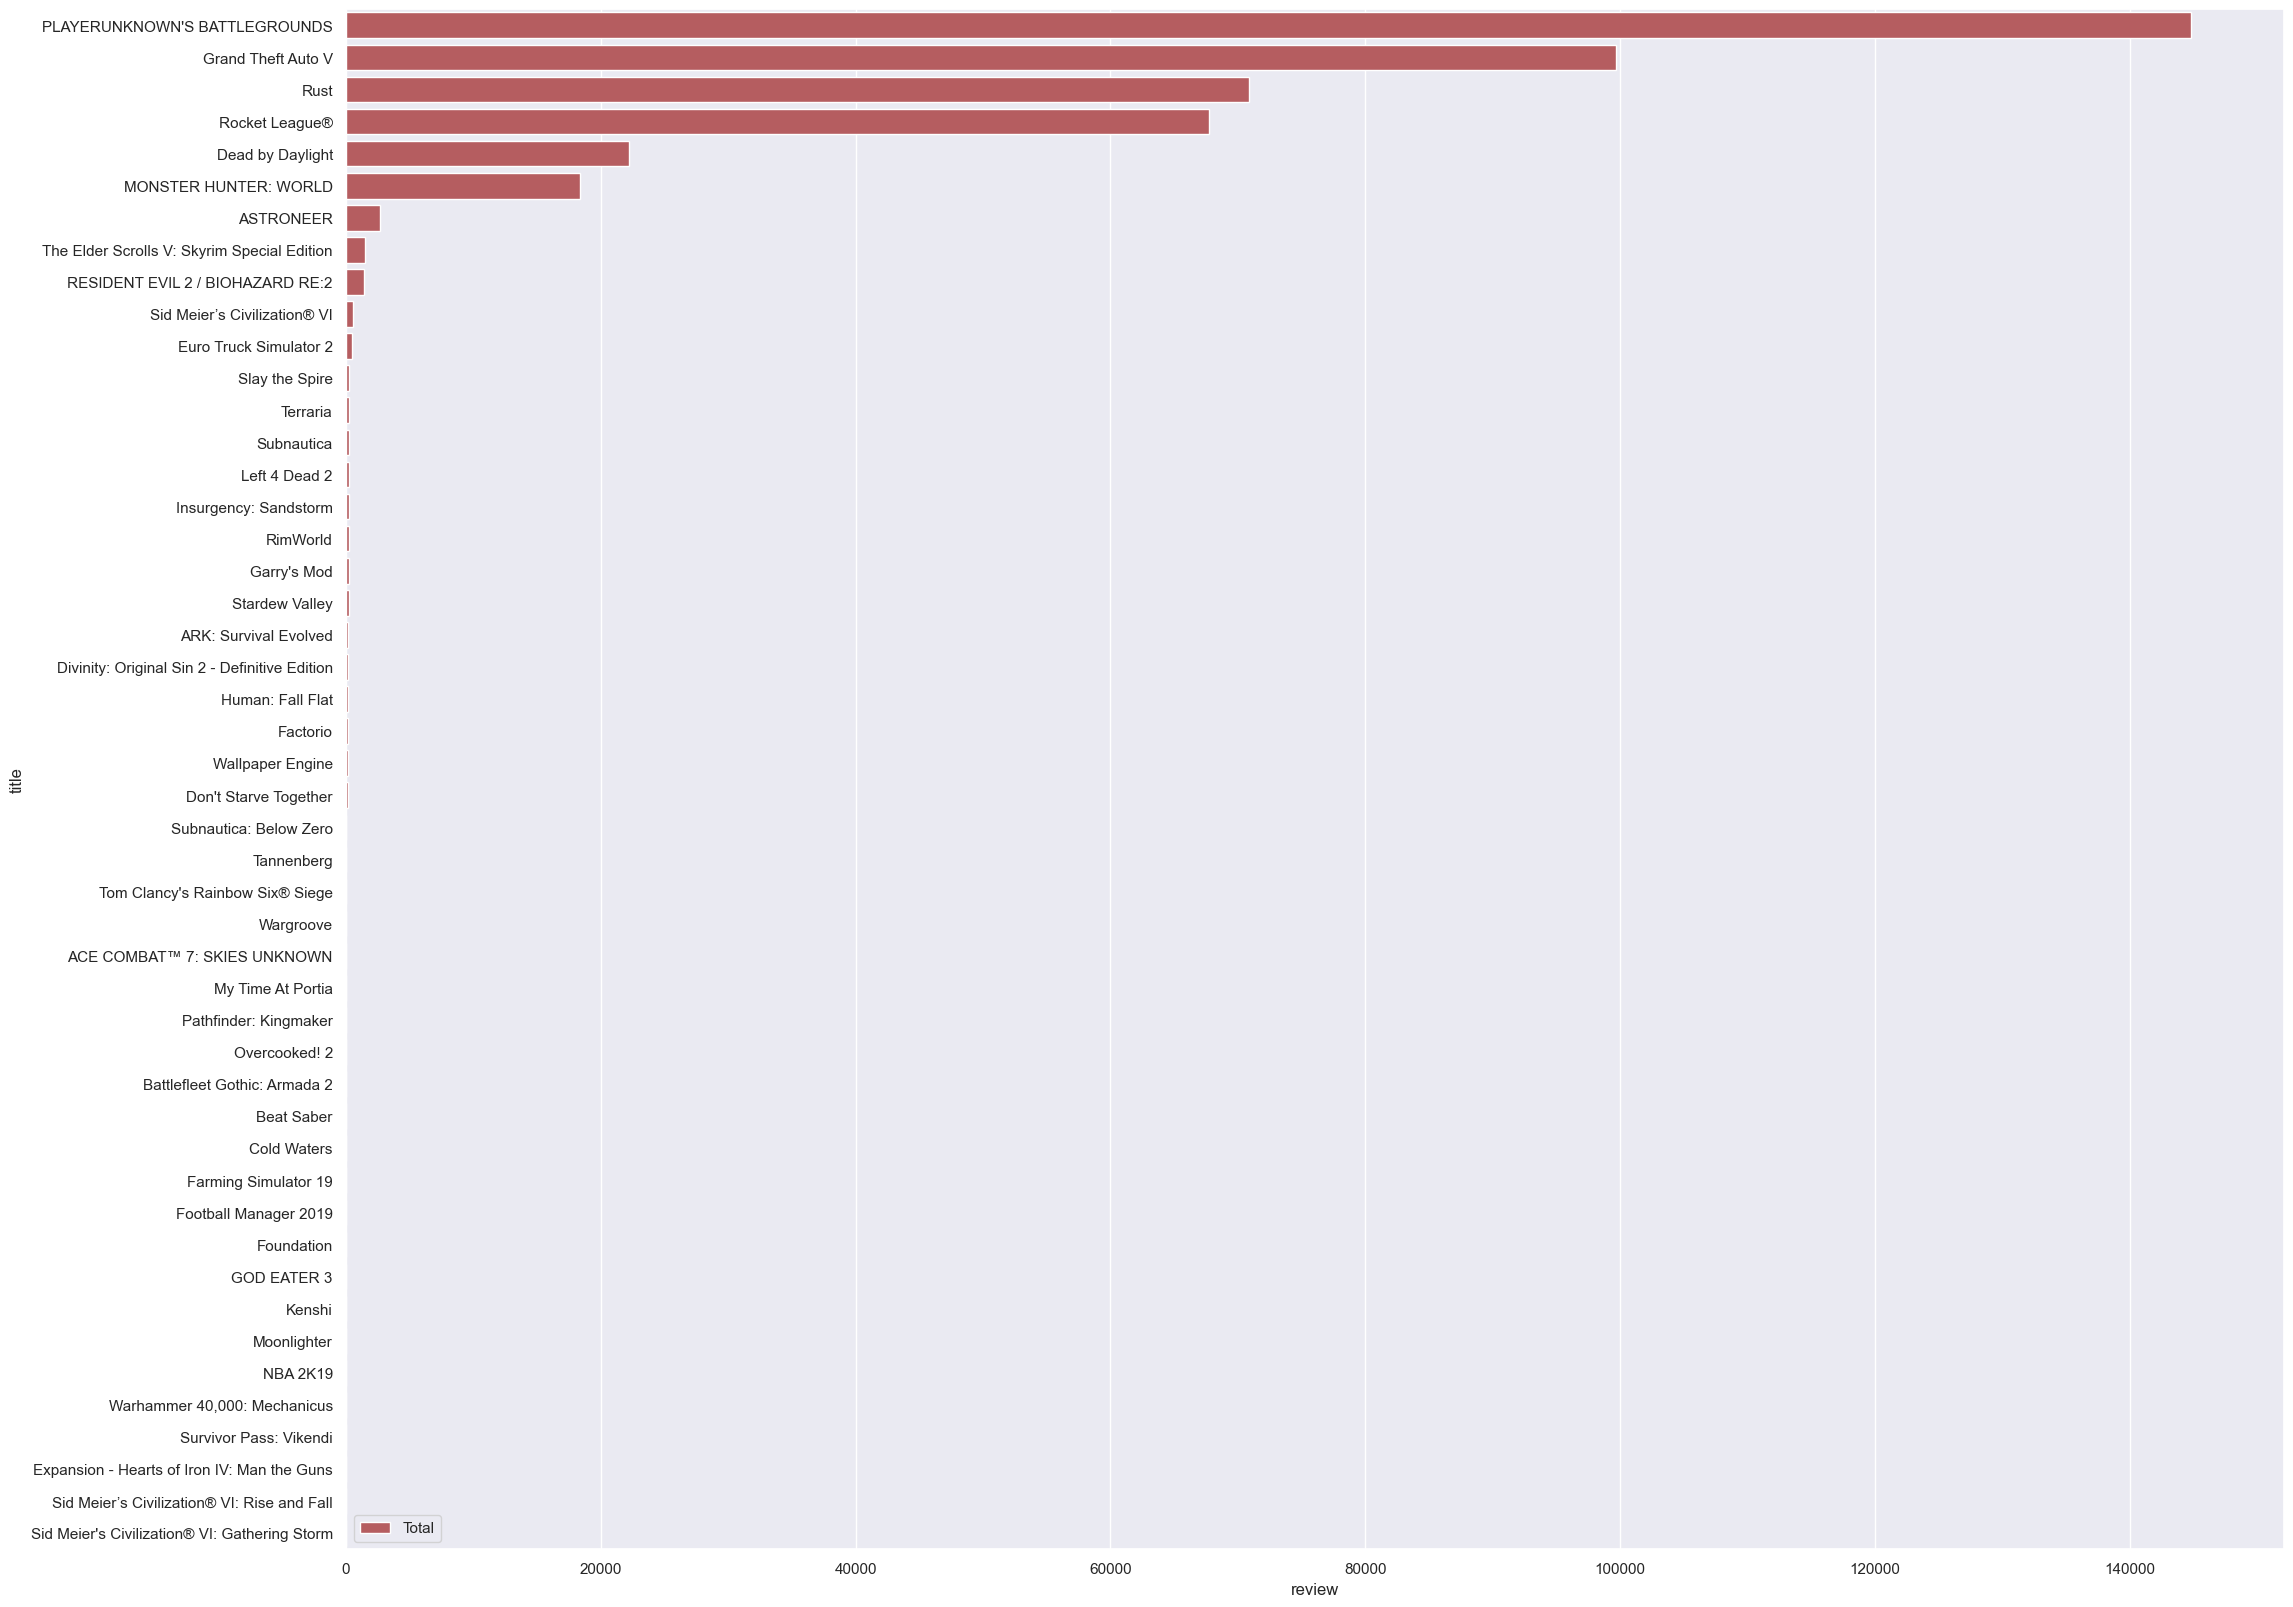

In [7]:
reviews_count = df.groupby(['title'])['review'].count().sort_values(ascending=False)

reviews_count = reviews_count.reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(25,20))
sns.barplot(y=reviews_count['title'], x=reviews_count['review'], data=reviews_count,
            label="Total", color="r")

1 The top game is the "Player Unknown's Battlegrounds", having the highest number of reviews.

2 The second game with the highest number of reviews is "Grand Theft Auto"

Then check how many games are recommended vs not recommended.

In [8]:
# Count samples per category
print(df['recommendation'].value_counts(), "\n")
print(df['recommendation'].value_counts(normalize=True))

recommendation
Recommended        303593
Not Recommended    131298
Name: count, dtype: int64 

recommendation
Recommended        0.69809
Not Recommended    0.30191
Name: proportion, dtype: float64


,proportion
recommendation,
Recommended,69.808987
Not Recommended,30.191013


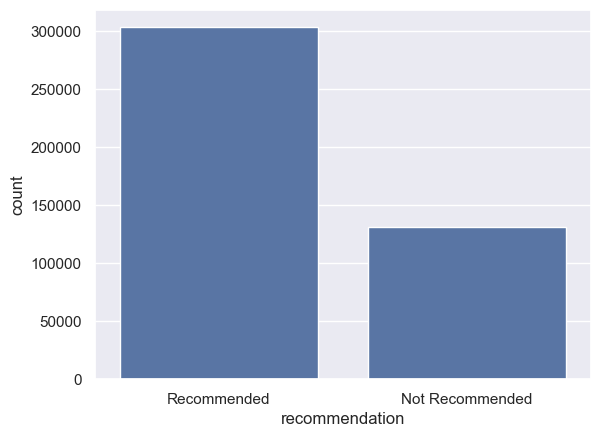

In [9]:
# Count plot of recommendation
sns.countplot(x='recommendation',data=df)

# Count in percentage
pd.DataFrame(df['recommendation'].value_counts(normalize=True)*100)

This data set contains predominantly positive ratings, with the number of positive ratings being more than twice as high as the number of negative ratings.

Another important aspect of the analysis is checking if there are rows with missing reviews.If such rows are found, then we drop them off as they contribute nothing to the implementation of the model